In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import re, nltk, catboost
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pprint
import numpy as np
from nltk.corpus import stopwords

## TITLES: 
<br> 
* Analysis and Clustering DevOps and Sys.Admins resumes. Is there any significant difference ?
<br>
* Resume Analysis with implementation of unsupervised ML algorithmes

In [2]:
data = pd.read_csv('lang.csv')

In [2]:
data = pd.read_csv('sysadmin-3m.csv/sysadmin-3m.csv')

In [3]:
# take a look at first 5 rows
data.head()

,position,location,salary_min,experience_years,english_level,employment,skills,moreinfo,looking_for,highlights,pokes
0,"Junior DevOps, Junior Python Developers",Одесса,1000,4.0,basic,fulltime remote,"Linux, bash, TCP/IP, Networking, DHCP, Cisco, ...",Работаю в продуктовой компании которая создаёт...,Интересные проекты и задачи с помощью которых ...,NaN,1
1,DevOps,"Киев,Львов,Remote",600,5.0,intermediate,fulltime remote move,"MySQL, Java, Maven, Spring, REST API, JPA, JDB...",Java\r\nTechnologies & frameworks: Hibernate S...,NaN,Java Developer with less than 2.5 year of expe...,1
2,DevOps engineer,Харьков,4000,11.0,fluent,fulltime remote,"Terraform, Docker, Jenkins, Ansible, Helm, Ama...","GCP (GKE, GCE), Docker, Kubernetes\r\nAWS (ECS...","Kharkiv only, senior role in devops team, long...",Last project responsibilities:\r\nMigrate micr...,8
3,DevOps,Киев,2500,11.0,upper,remote freelance,"Linux, MySQL, Nginx, Docker, Jenkins, Python, ...","AWS, Ansible, Docker, Grafana, Jenkins, Kubern...",I would like to find a company that is glad to...,Have more than 12 years experience in SysOps a...,10
4,DevOps engineer,Харьков,2000,3.0,intermediate,freelance,"Linux, bash, MySQL, Git, Nginx, Networking, AW...",The current role in the project related to the...,NaN,NaN,8


In [4]:
data.describe()

,salary_min,experience_years,pokes
count,631.000000,631.000000,631.000000
mean,1842.393027,6.268621,23.202853
std,1408.234562,3.780111,29.342857
min,100.000000,0.000000,1.000000
25%,800.000000,3.000000,5.000000
50%,1500.000000,6.000000,13.000000
75%,2500.000000,11.000000,29.500000
max,7500.000000,11.000000,263.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 11 columns):
position            631 non-null object
location            626 non-null object
salary_min          631 non-null int64
experience_years    631 non-null float64
english_level       626 non-null object
employment          631 non-null object
skills              603 non-null object
moreinfo            598 non-null object
looking_for         421 non-null object
highlights          323 non-null object
pokes               631 non-null int64
dtypes: float64(1), int64(2), object(8)
memory usage: 54.3+ KB


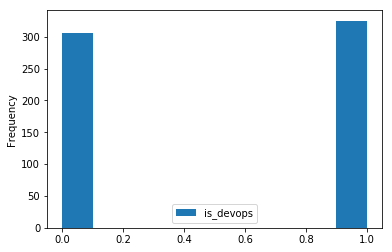

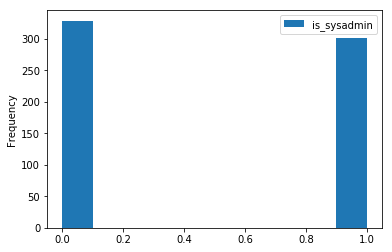

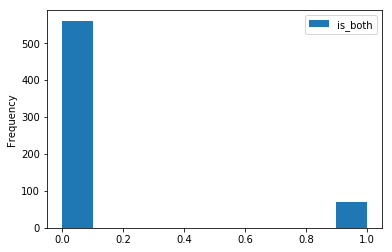

In [3]:
# Vacancy distribution 
# Here I will extract whether person is looking for sys.admin job or devops 
# Show distributional graphs

# people, who are looking for devops position
data['is_devops'] = data['position'].apply(lambda x: 1 if 'devops' in x.lower() else 0)
data[['is_devops']].plot(kind = 'hist',label='Is DevOps')

# people, who consider sysAdmin position
data['is_sysadmin'] = data['position'].apply(lambda x: 1 if 'системный администратор' in x.lower() 
                                            or 'administrator' in x.lower() or 'system' in x.lower() else 0)
data[['is_sysadmin']].plot(kind = 'hist',label='Is SysAdmin')

# people, who consider both positions
data['is_both'] = data['is_devops']*data['is_sysadmin']
data[['is_both']].plot(kind = 'hist',label='Both')


Provided data are pretty balanced,meaning that people, who are looking for SysAdmin and DevOps jobs presented in rougly same amount. 
However, there is small percent of people, that considers both of the position - either they are qualified to do both, or they believe it is the same position. Lets take a look at their moreinfo and looking_for columns closer

In [21]:
# Lets print descriptions of people, who consider both positions

for _, row in data[data['is_both'] == 1].iterrows():
    print(row['moreinfo'])
    print()
    print(row['looking_for'])
    print('\n\n')

More than 4 years

Solving user problems from Europe, India, USA, and Kiev
location. System administration, troubleshooting, working with
Windows server 2012 R2, WDS, GPO, DNS, RSA tokens for
Cisco VPN, configure Cisco Hard/Softphone. Working with
Solarwinds ticket systems, PRTG, installing ESXi for R&D team,
creating basic Powershell scripts for automation daily grind tasks.

I strive to develop in the directions of Unix-like operating systems and be useful in a new place of work.

Interesting tasks, new technology



Installation, automation, maintenance and troubleshooting company cloud environment. Implementation CI/CD process.
Installation, maintenance and troubleshooting customers servers in datacenters. Supporting IT infrastructure.

nan



DevOps 1+
Admin 4 years

- Небольшая компания, желательно с хедофисом за рубежом
- Возможность частичной удаленки
- Хороший соцпакет
- Спокойная атмосфера
- Без заданий "нужно на вчера", "хочу мышкой открывать окна"
- Время на учебу
- Чтобы б

After looking at texts, looks like majority thinks, that the jobs are similar to each other. Still, there are some of them, who worked on both positions and separate this experience in their resumes.

# Resume analysis

I will start with some major text data analysis. In order to do this I will consider:
    <br> -> the most common n-grams and visualize some graphs
    <br> -> split texts into different clusters and will closer look at them 

* All abovementioned steps require text cleaning and preprocessing

Another challenge is that there are plenty of different languages, that are represented here. So, I will perform analysis separately for all of them.

In [17]:
# checking how many languages are in corpus

def detect_language(text):
    try: 
        return  TextBlob(text).detect_language()
    except:
        return 'Unknown Language'

data['language'] = data['moreinfo'].apply(detect_language)
data['looking_for_language'] = data['looking_for'].apply(detect_language)
print('Total amount of languages: ', len(set(data['language'].unique().tolist() + data['looking_for_language'].unique().tolist())))

Total amount of languages:  8


In [19]:
pprint.pprint(set(data['language'].unique().tolist() + data['looking_for_language'].unique().tolist()))

{'id', 'en', 'bg', 'uk', 'ru', 'Unknown Language', 'cy', 'su'}


Lets check distribution of languages before starting other steps

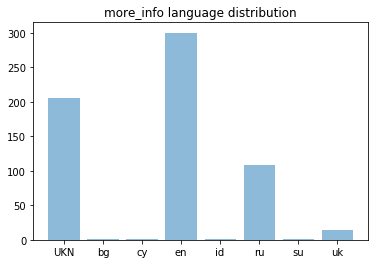

In [27]:
# Showing graphs distributions (moreinfo column)

language_amount_moreinfo = []
language_name_moreinfo = []

for name, df in data.groupby('language'):
    language_amount_moreinfo.append(len(df))
    language_name_moreinfo.append(name)
language_name_moreinfo = [x if x!= 'Unknown Language' else 'UKN' for x in language_name_moreinfo]

plt.bar(np.arange(len(language_amount_moreinfo)),language_amount_moreinfo,align='center', alpha=0.5)
plt.xticks(np.arange(len(language_name_moreinfo)),language_name_moreinfo)
plt.title('more_info language distribution')
plt.show()

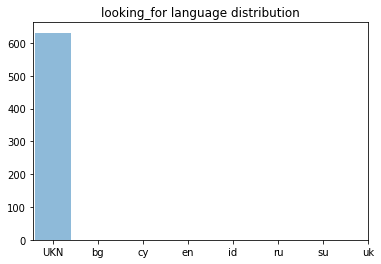

In [28]:
# Showing graphs distributions (looking_for column)

language_amount_looking = []
language_name_looking = []

for name, df in data.groupby('looking_for_language'):
    language_amount_looking.append(len(df))
    language_name_looking.append(name)
language_name_looking = [x if x!= 'Unknown Language' else 'UKN' for x in language_name_moreinfo]

plt.bar(np.arange(len(language_amount_looking)),language_amount_looking,align='center', alpha=0.5)
plt.xticks(np.arange(len(language_name_looking)),language_name_looking)
plt.title('looking_for language distribution')
plt.show()

Well, looks like it is too tricky to detect language in looking_for column. I believe, the reason for this effect is in occurances of english terminology alongside of description. 

But anyway, I think, that moreinfo column provides us with pretty decent information about languages candidates use the most: english, russian and ukrainian. 

Lets take a look at word and n-grams distribution for each of them.

In [60]:
# function to return n the most frequent words in given corpus

def get_top_n_words(corpus, n=30, ngram_range = (1,1)):
    
    vec = CountVectorizer(ngram_range = ngram_range, lowercase = True,
                          stop_words=stopwords.words('english')).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [31]:
# loading all text at one column

data['all_text'] = data['moreinfo'].apply(lambda x: str(x) +'\n') + data['looking_for']

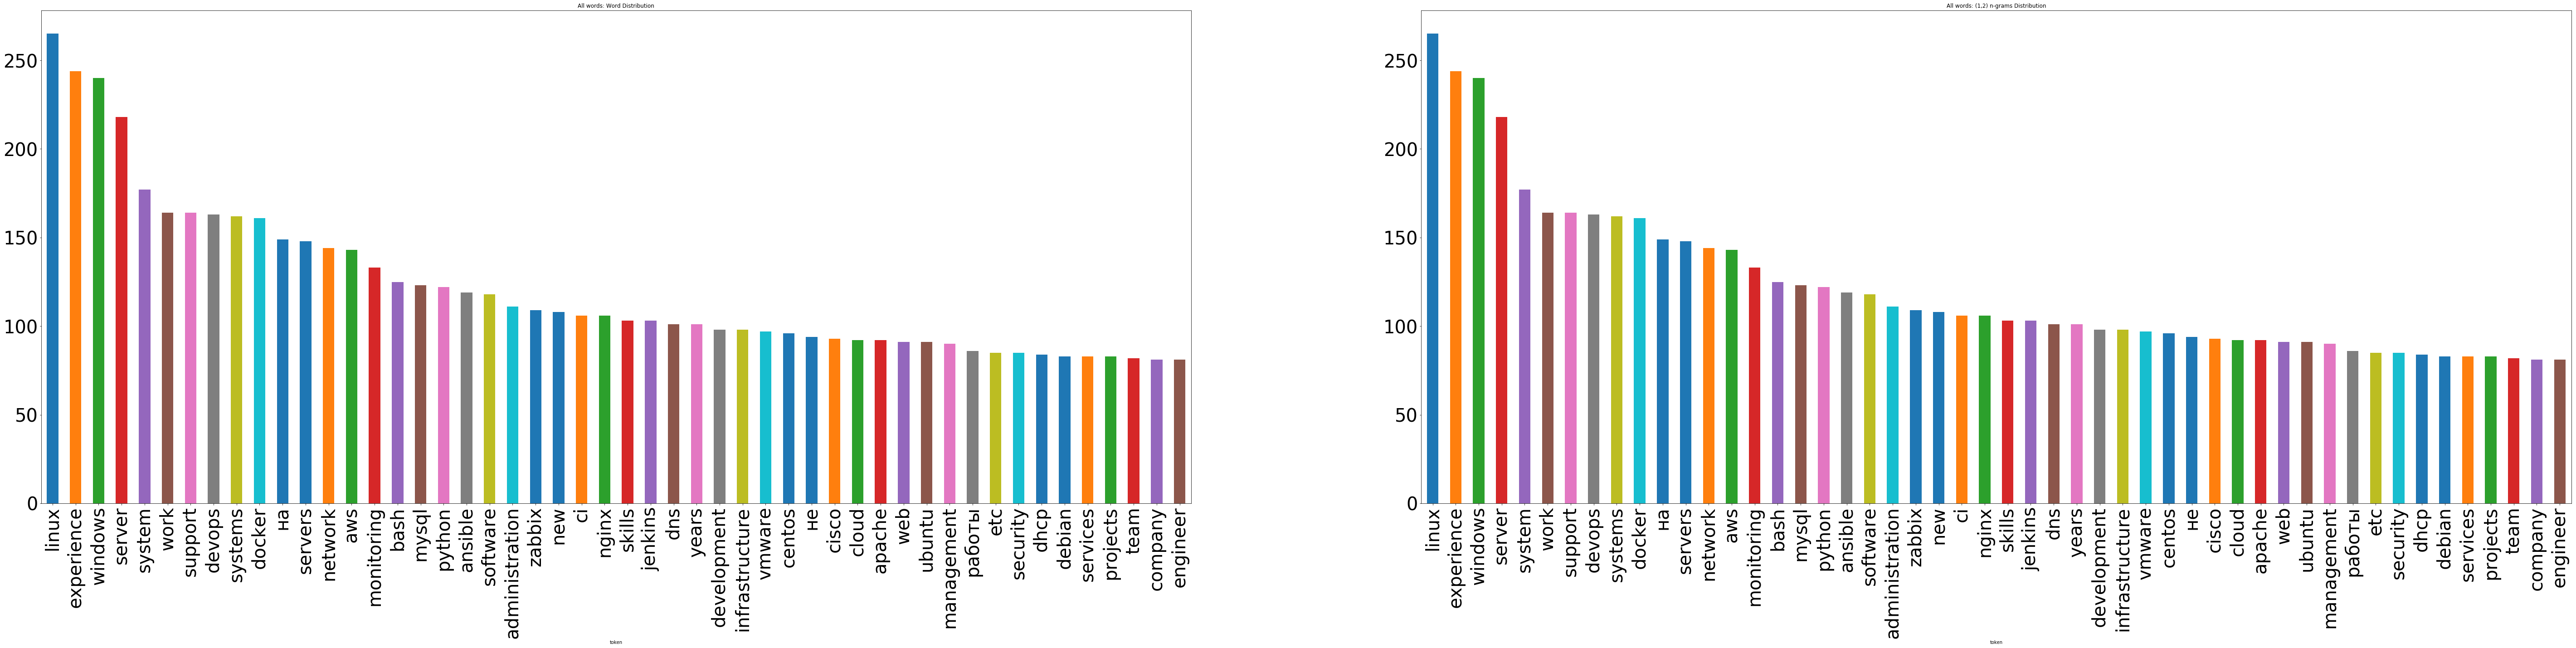

In [12]:
# Lets take a look at the most common words/n-grams, that are used in text without language stratification

n = 50
df_all = data['all_text'].dropna()
top_words = get_top_n_words(df_all.values, n=n)
top_words_2grams = get_top_n_words(df_all.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='All words: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='All words: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)


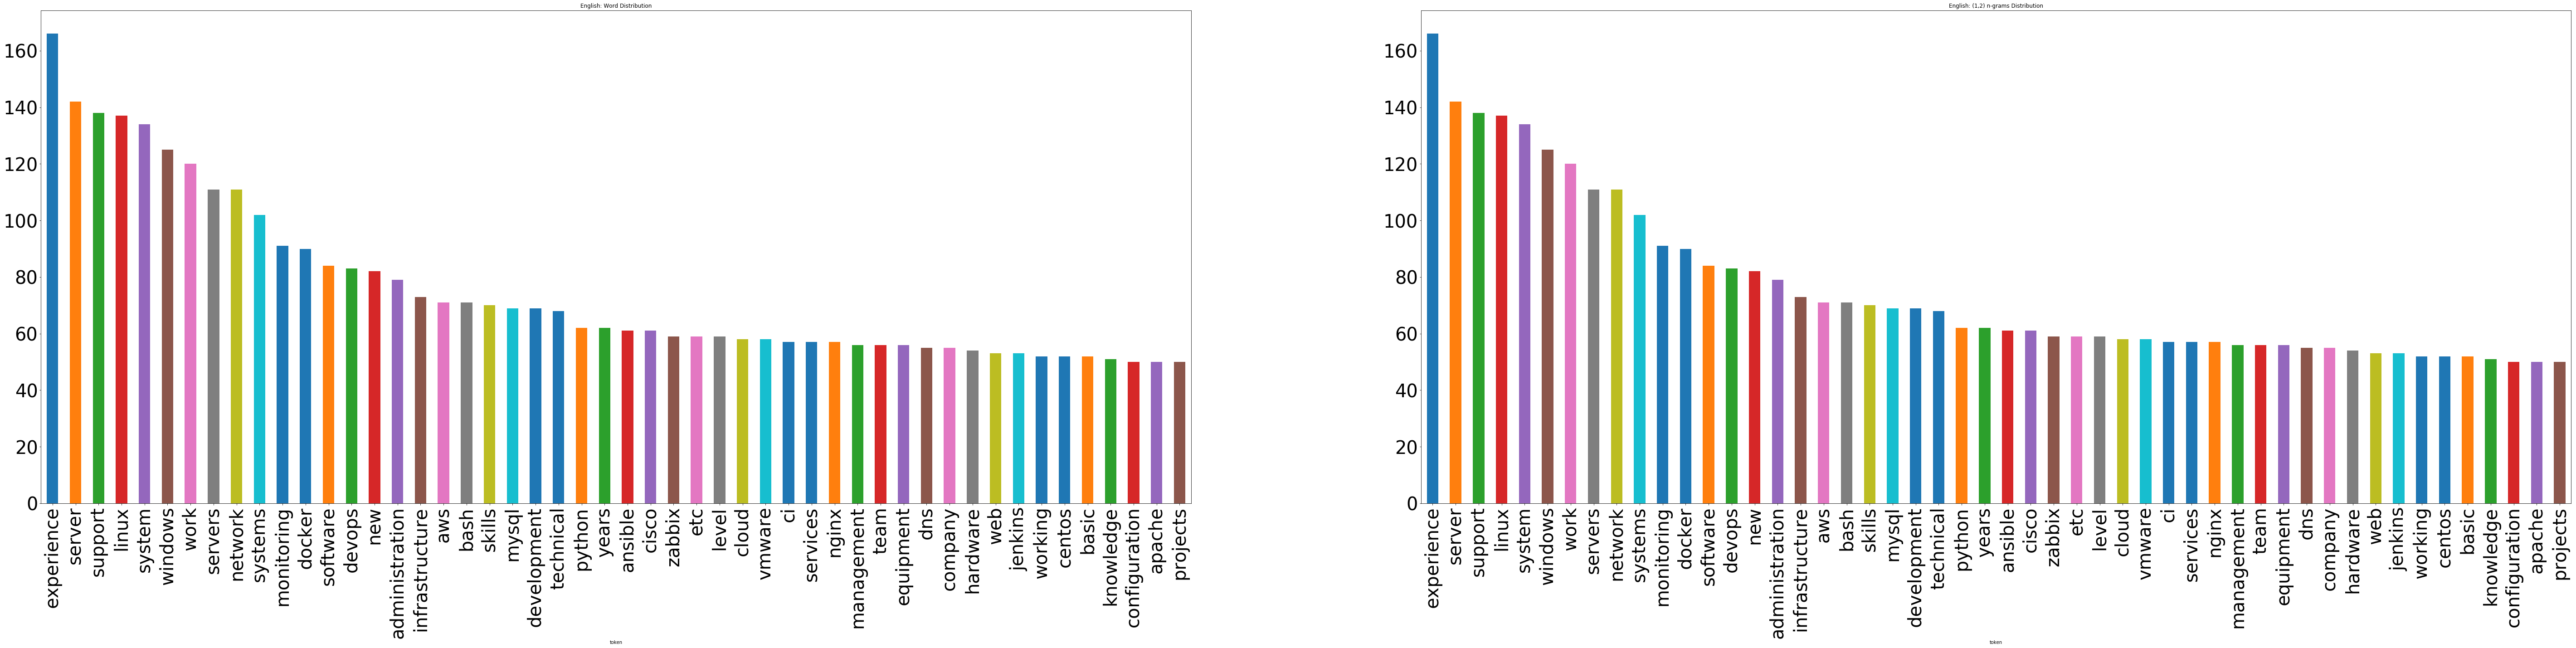

In [13]:
# English word distribution calculation

n = 50
df_en = data[data['language'] == 'en']['all_text'].dropna()
top_en_words = get_top_n_words(df_en.values, n=n)
top_en_words_2grams = get_top_n_words(df_en.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_en_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='English: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_en_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='English: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

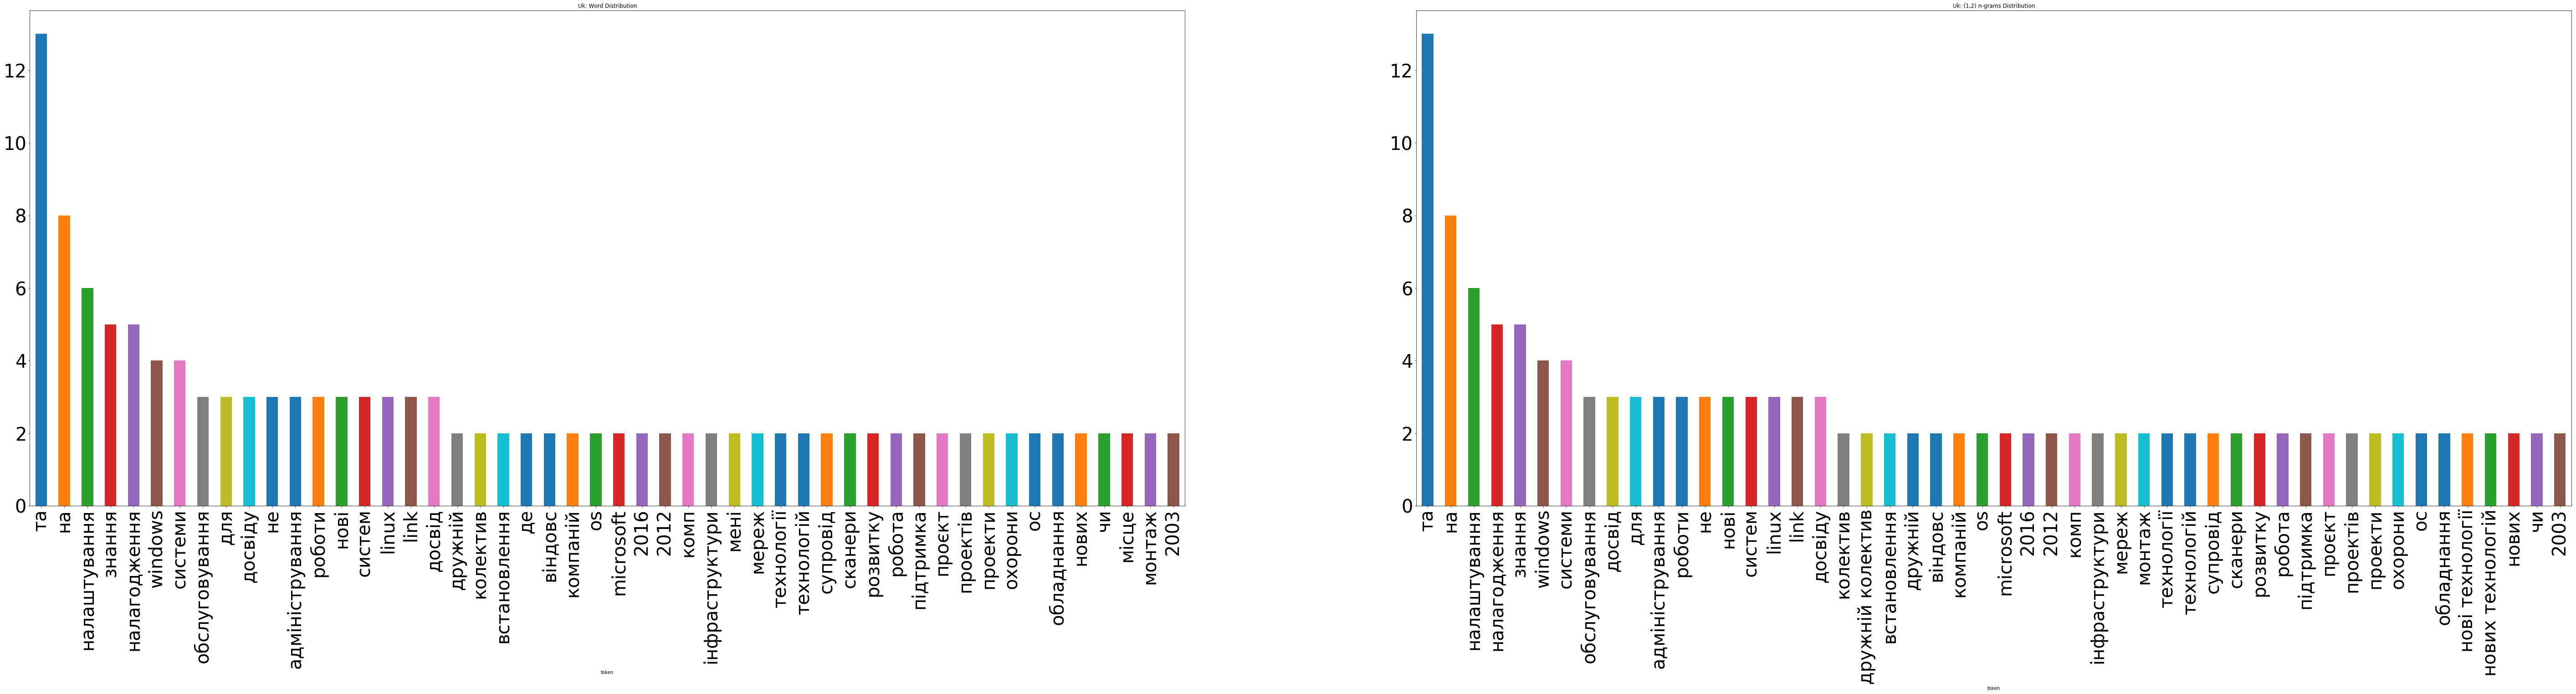

In [15]:
# Ukrainian word distribution calculation

n = 50
df_uk = data[data['language'] == 'uk']['all_text'].dropna()
top_uk_words = get_top_n_words(df_uk.values, n=n)
top_uk_words_2grams = get_top_n_words(df_uk.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_uk_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Uk: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_uk_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Uk: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

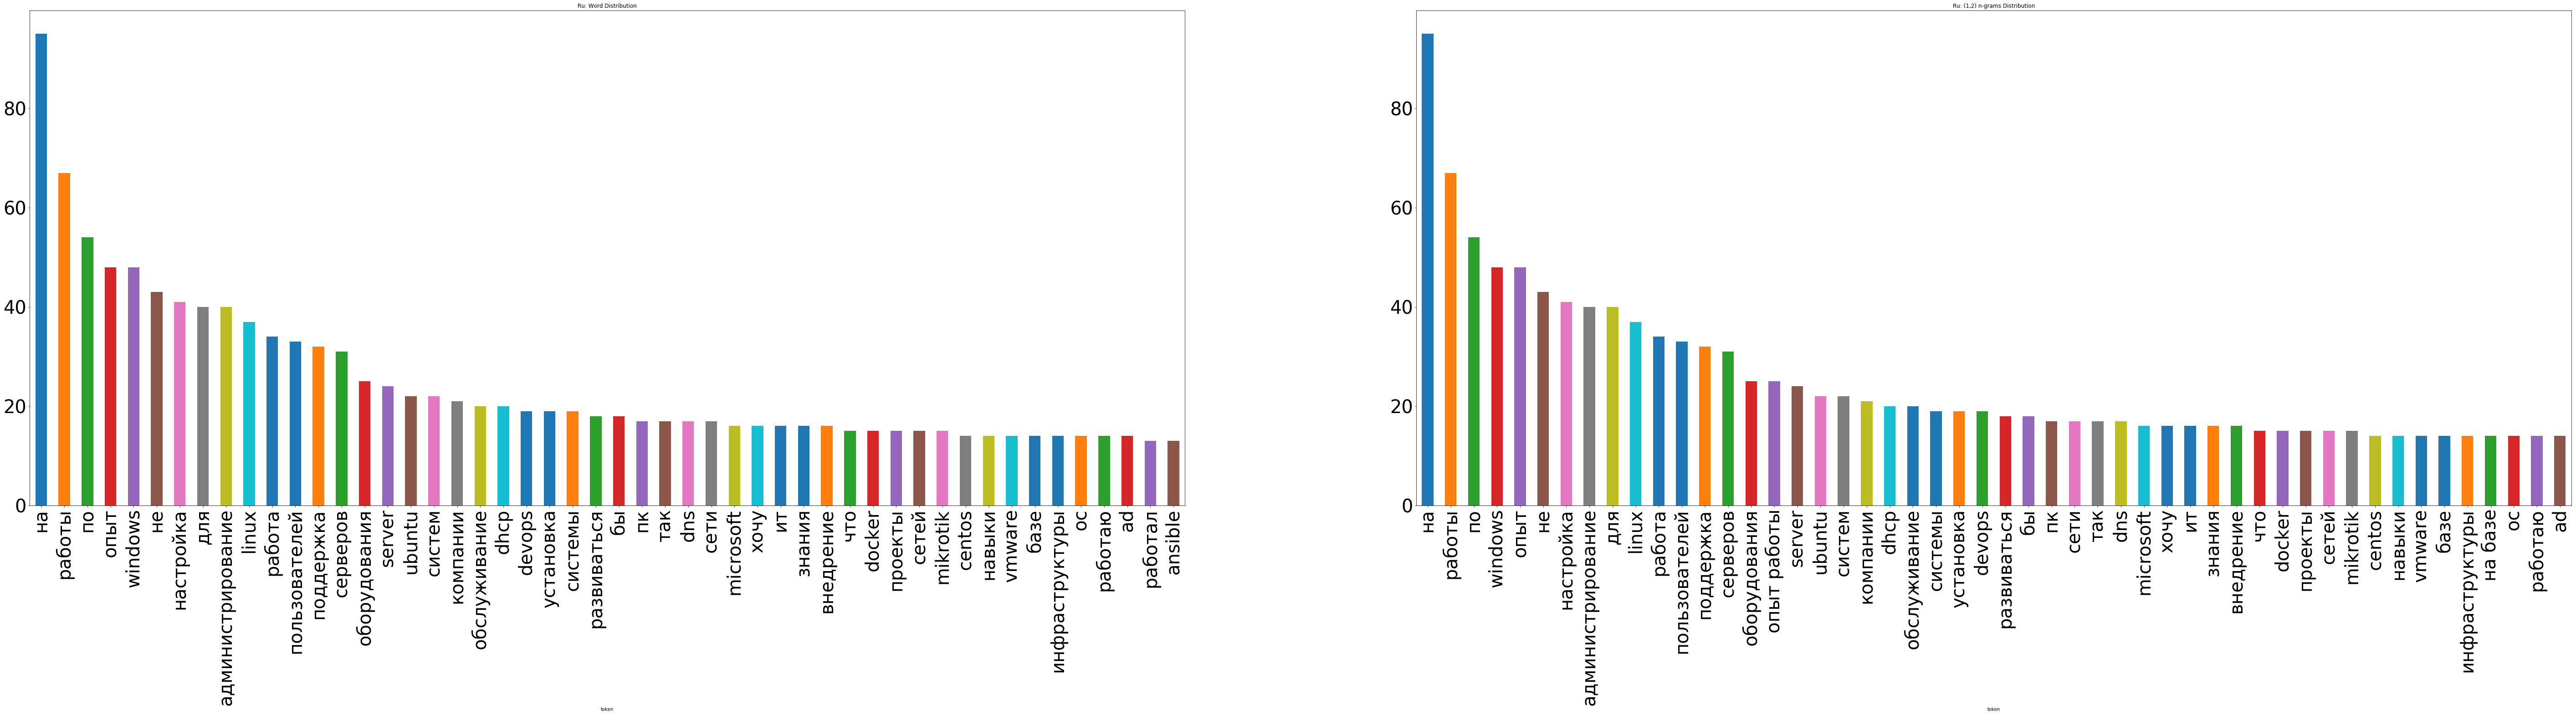

In [16]:
# Russian word distribution calculation

n = 50
df_ru = data[data['language'] == 'ru']['all_text'].dropna()
top_ru_words = get_top_n_words(df_ru.values, n=n)
top_ru_words_2grams = get_top_n_words(df_ru.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_ru_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Ru: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_ru_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Ru: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

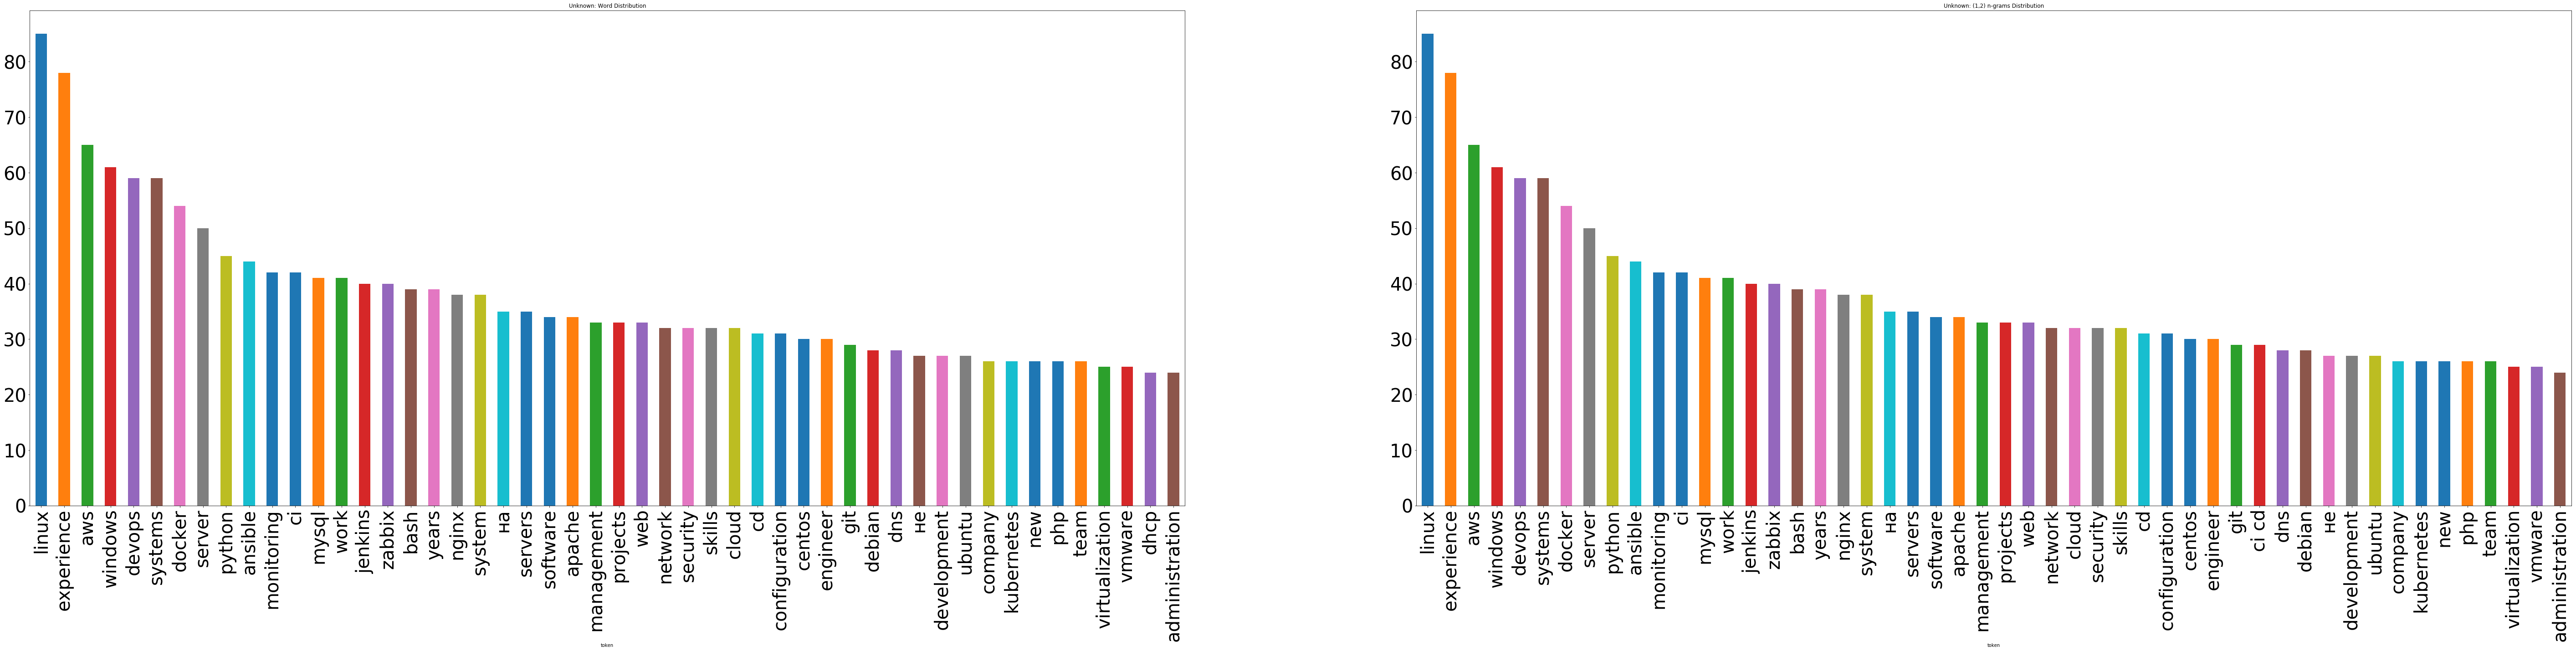

In [17]:
# Unknown language word distribution calculation

n = 50
df_un = data[data['language'] == 'Unknown Language']['all_text'].dropna()
top_un_words = get_top_n_words(df_un.values, n=n)
top_un_words_2grams = get_top_n_words(df_un.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_un_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Unknown: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_un_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Unknown: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)


As we can see, there is small amount of n-grams in word distributions.
Well, it means, that styles of people are different and despite using same words, they avoid using the same n-grams. I believe, it is caused by trying to make resume looks unique and original.

Also, graphs shows, that majority of words are written in English. Moreover, data, that was marked as unknown, also shows dominance of english words.  

Now, I would like to do the same text analysis, but for each job/jobs:
For DevOps, Sys.Admin and both of them

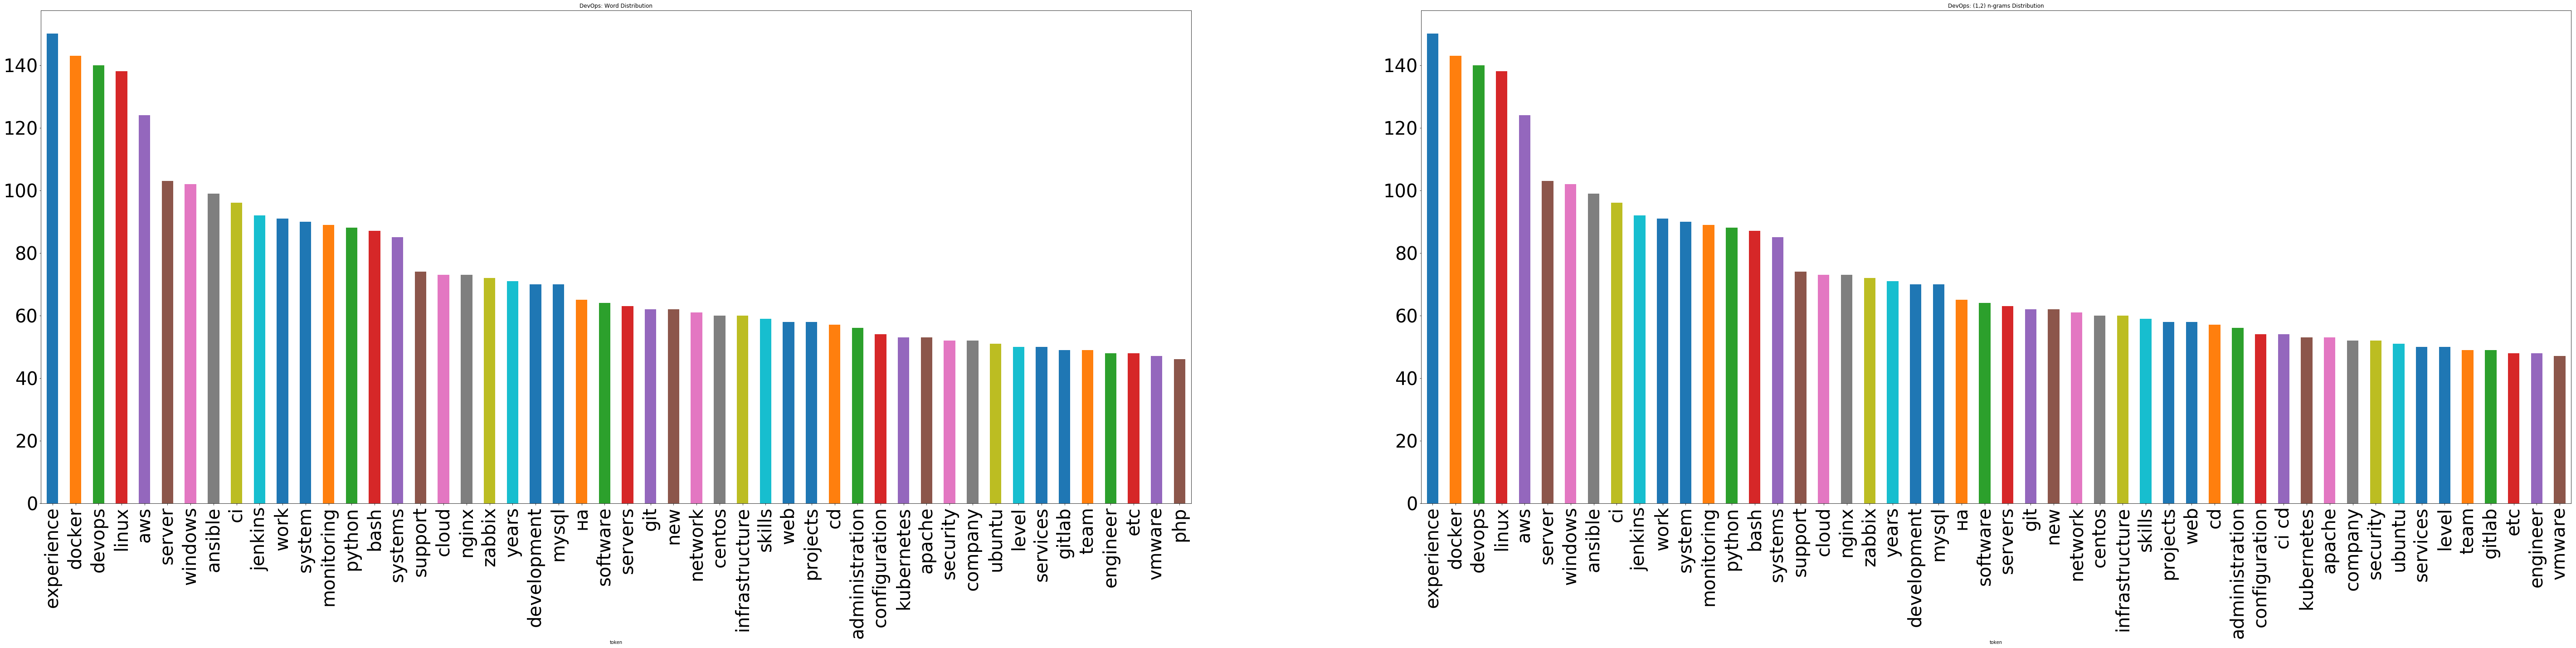

In [10]:
# DevOps word distribution calculation

n = 50
df_dops = data[data['is_devops'] == 1]['all_text'].dropna()
top_dops_words = get_top_n_words(df_dops.values, n=n)
top_dops_words_2grams = get_top_n_words(df_dops.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_dops_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='DevOps: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_dops_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='DevOps: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

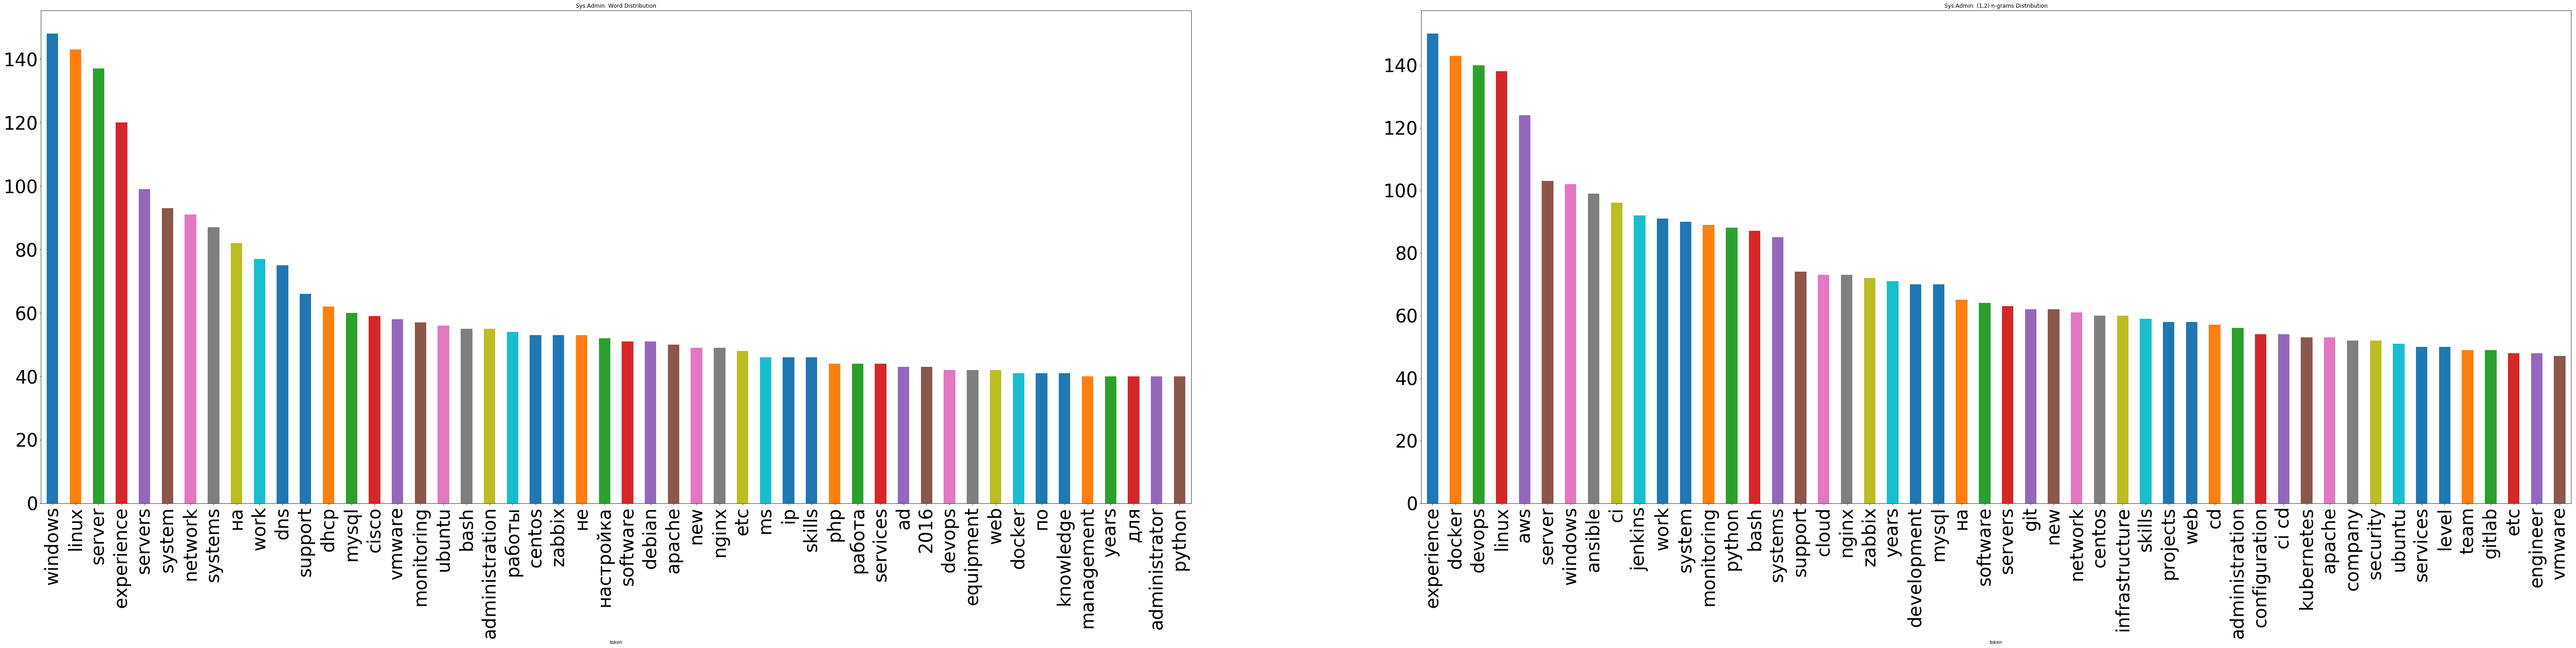

In [18]:
# Sys.Admin word distribution calculation

n = 50
df_sa = data[data['is_sysadmin'] == 1]['all_text'].dropna()
top_sa_words = get_top_n_words(df_sa.values, n=n)
top_sa_words_2grams = get_top_n_words(df_dops.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_sa_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Sys.Admin: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_sa_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Sys.Admin: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

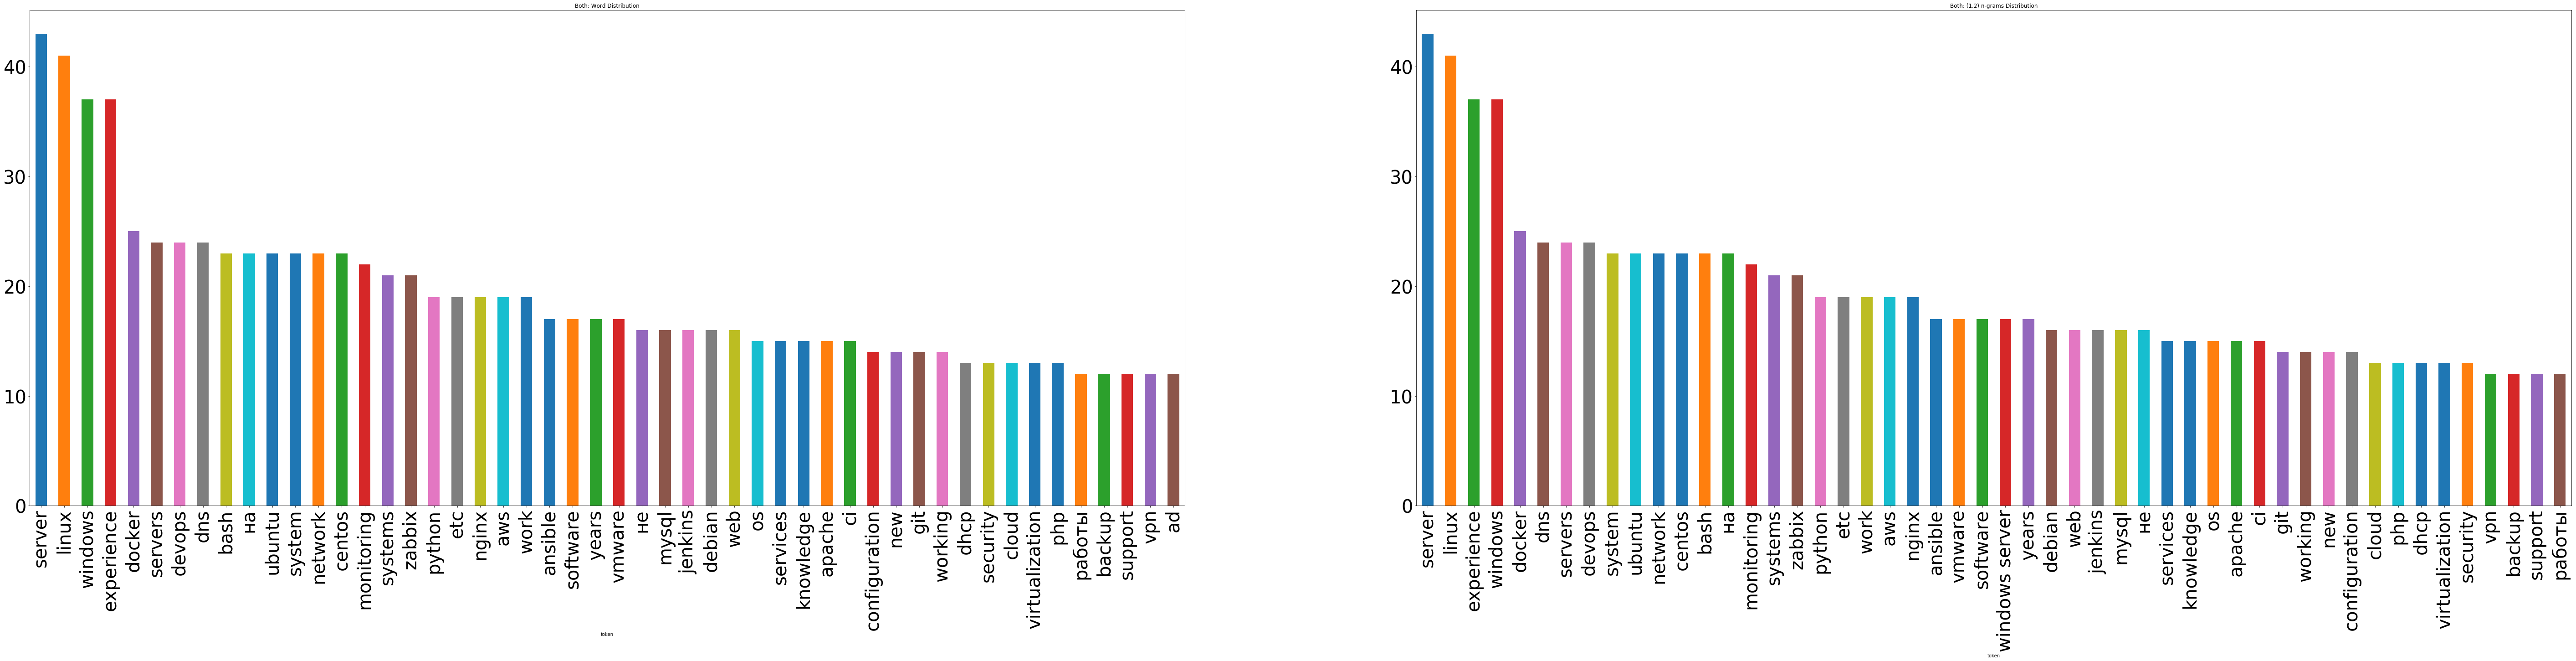

In [22]:
# Both jobs candidate word distribution calculation

n = 50
df_both = data[data['is_both'] == 1]['all_text'].dropna()
top_both_words = get_top_n_words(df_both.values, n=n)
top_both_words_2grams = get_top_n_words(df_both.values, n=n, ngram_range=(1,2))

# plotting

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

freq_words = pd.DataFrame(top_both_words, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Both: Word Distribution', ax  = ax1,fontsize = 40)

freq_words = pd.DataFrame(top_both_words_2grams, columns = ['token' , 'count'])
freq_words.groupby('token').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Both: (1,2) n-grams Distribution', ax  = ax2,fontsize = 40)

Well, from graphics of word frequences there are obvious some difference between most common words.
Lets take a closer look.

In [20]:
# most common words of Sys.Admins, that are not included in DevOps most common list

sa_difference = set([x[0] for x in top_sa_words]).difference(set([x[0] for x in top_dops_words]))
pprint.pprint(sa_difference)

{'2016',
 'ad',
 'administrator',
 'cisco',
 'debian',
 'dhcp',
 'dns',
 'equipment',
 'ip',
 'knowledge',
 'management',
 'ms',
 'для',
 'настройка',
 'не',
 'по',
 'работа',
 'работы'}


In [21]:
# most common words of DevOps, that are not included in  Sys.Admins most common list

sa_difference = set([x[0] for x in top_dops_words]).difference(set([x[0] for x in top_sa_words]))
pprint.pprint(sa_difference)

{'ansible',
 'aws',
 'cd',
 'ci',
 'cloud',
 'company',
 'configuration',
 'development',
 'engineer',
 'git',
 'gitlab',
 'infrastructure',
 'jenkins',
 'kubernetes',
 'level',
 'projects',
 'security',
 'team'}


In [23]:
# Intersection of most common words

sa_inter = set([x[0] for x in top_sa_words]).intersection(set([x[0] for x in top_dops_words]))
pprint.pprint(sa_inter)

{'administration',
 'apache',
 'bash',
 'centos',
 'devops',
 'docker',
 'etc',
 'experience',
 'linux',
 'monitoring',
 'mysql',
 'network',
 'new',
 'nginx',
 'php',
 'python',
 'server',
 'servers',
 'services',
 'skills',
 'software',
 'support',
 'system',
 'systems',
 'ubuntu',
 'vmware',
 'web',
 'windows',
 'work',
 'years',
 'zabbix',
 'на'}


What is interesting, that for sys.admins russian words are more popular than for devops position seekers. It could be because potencial DevOps is trying to find job not only in their native country, but abroad more often, than sysadmins.

Considering graphs, the hypothesis is that the difference of Devopses are usually in working with kubernetes, infrastructure, git and gitlab.

Sys.Admins : cisco, debian, dhcp, dns and ms. 

But in both jobs it is important to have understanding of: windows, web, python, php, linux, mysql, centos, docker.
<br> Lets take a look at english level distributions as well.

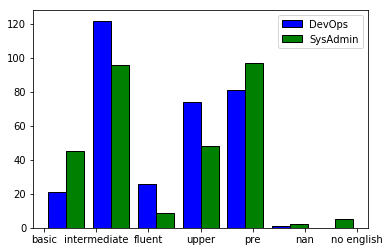

In [28]:
plt.hist([data[data['is_devops'] == 1]['english_level'].tolist(),
         data[data['is_sysadmin'] == 1]['english_level'].tolist()],
        color=['b','g'],
        bins = len(data['english_level'].unique()),label = ['DevOps', 'SysAdmin'],edgecolor='black')
plt.legend()
plt.show()

So, as it could be seen on graphs, english level of DevOps candidates is a little different from SysAdmins. Moreover,looks like the language skills are distributed in same way, but: 
<br> There are more SysAdmins on pre and basic levels, but the difference is not significant enough - like 20 person for each;
<br> There are more upper and intermediate english level DevOps candidates with similar difference. So, I think, that English level of DevOps are slightly better, comparing to SysAdmins. 

# Expected Salary distribution

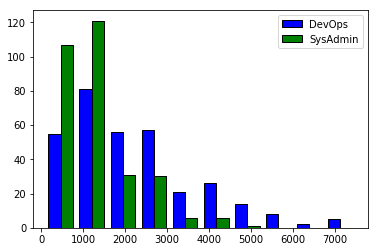

In [62]:
plt.hist([data[data['is_devops'] == 1]['salary_min'].tolist(),
         data[data['is_sysadmin'] == 1]['salary_min'].tolist()],
        color=['b','g'], label = ['DevOps', 'SysAdmin'],edgecolor='black')
plt.legend()
plt.show()


In [65]:
# Lets take a look at statistics of salaries
data[data['is_devops'] == 1]['salary_min'].describe()

count     325.000000
mean     2286.769231
std      1523.547788
min       250.000000
25%      1000.000000
50%      2000.000000
75%      3000.000000
max      7500.000000
Name: salary_min, dtype: float64

In [66]:
data[data['is_sysadmin'] == 1]['salary_min'].describe()

count     302.000000
mean     1308.609272
std       881.486618
min       100.000000
25%       700.000000
50%      1000.000000
75%      1500.000000
max      5000.000000
Name: salary_min, dtype: float64

So, SysAdmins are expecting to be paid less, than DevOpses. From this graph, looks like it is much more easier to find SysAdmin for a salary in range (500, 1500) than DevOps. Salary of 2000 is also possible for SysAdmins, but looks like it is a limit for this job title, considering given data. However, there are devOpses, who are expecting salary more than 2000.
<br> Moreover, the mean salary expectation of DeVops is much higher, than of Sys.Admin.
<br> Lets check, who actually has a poke with expected salary.


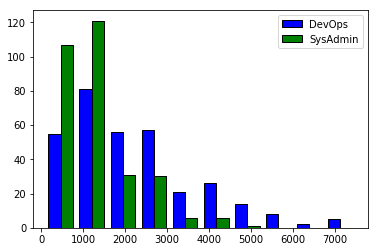

In [64]:
plt.hist([data[(data['is_devops'] == 1) & (data['pokes'] >=1)]['salary_min'].tolist(),
         data[(data['is_sysadmin'] == 1) & (data['pokes'] >=1)]['salary_min'].tolist()],
        color=['b','g'], label = ['DevOps', 'SysAdmin'],edgecolor='black')
plt.legend()
plt.show()

Well, graph hasn\`t changed much: looks like employers are OK with the prices, provided by the candidates.  

## Skill Analysis

Each applicant for a job defines the most important list of skills for the position. Lets check, what skills are prefarable by employers and what - by employees.

In order to do that, I will sort data with count of pokes and will count skills, that were presented

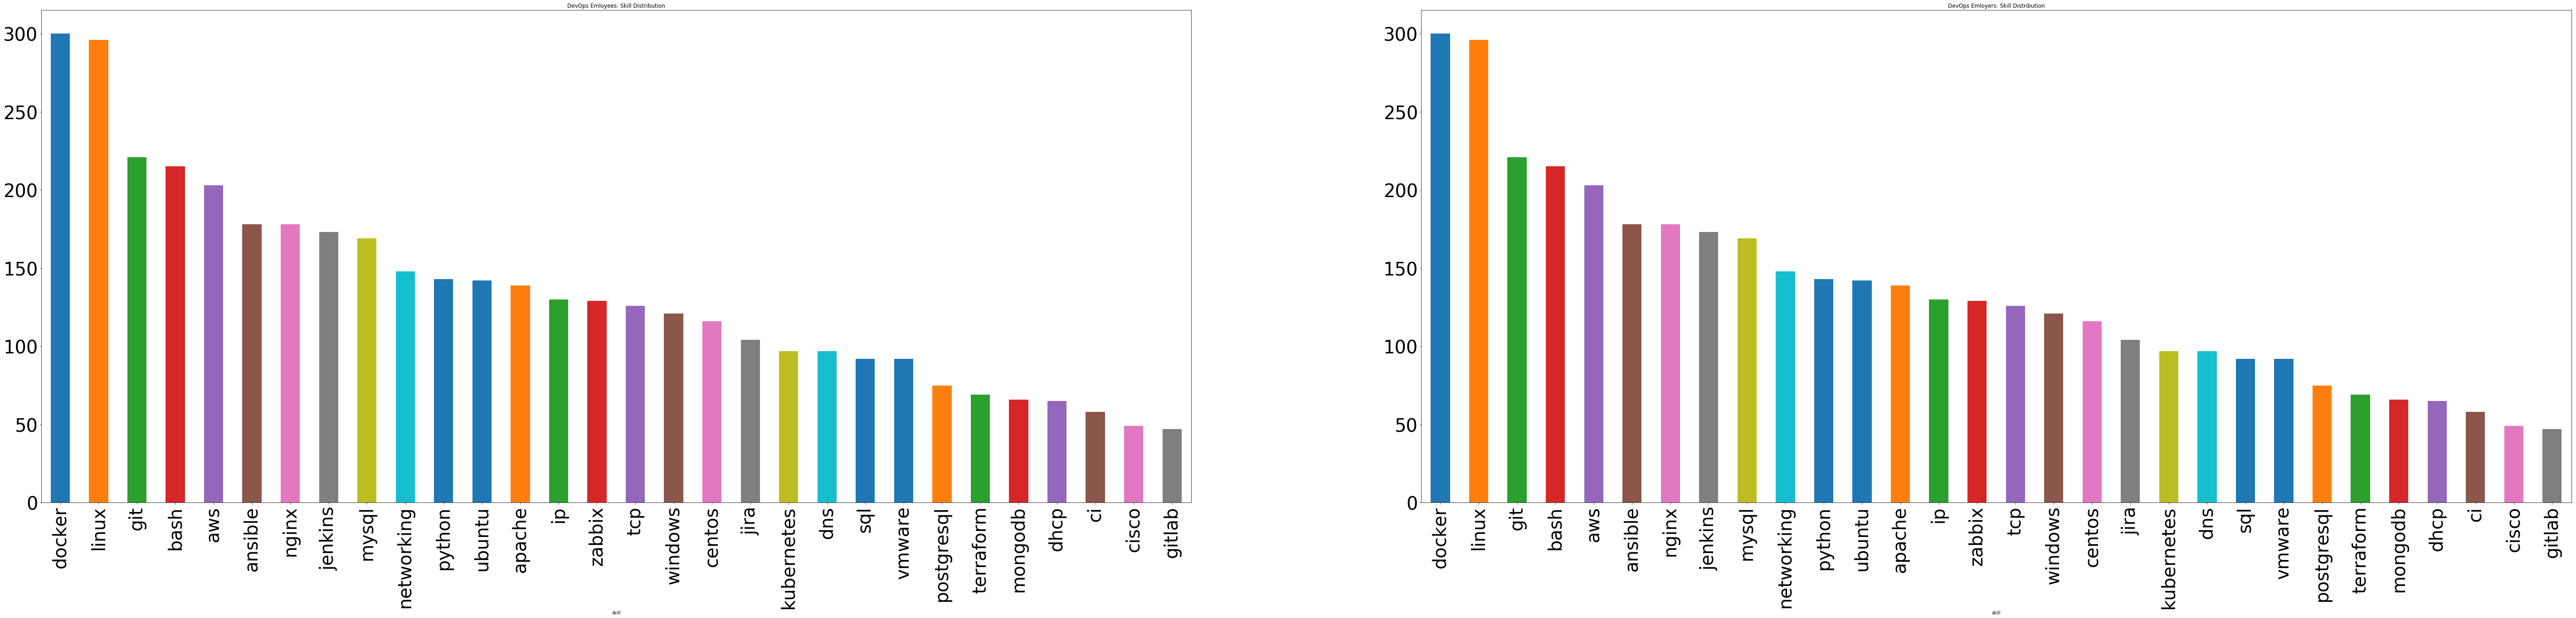

In [43]:
# Checking skills by devoops emloyers


n = 30
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

# loading data for devops
df_devops_skills = data[data['is_devops'] == 1]
top_devops_skills = get_top_n_words(df_devops_skills['skills'].dropna().values, n=n)

# plotting 
freq_skills = pd.DataFrame(top_devops_skills, columns = ['skill' , 'count'])
freq_skills.groupby('skill').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='DevOps Emloyees: Skill Distribution',fontsize = 40,ax = ax1)

df_devops_skills = df_devops_skills[df_devops_skills['pokes'] >=1]['skills'].dropna()
top_devops_skills = get_top_n_words(df_devops_skills.values, n=n)

freq_skills = pd.DataFrame(top_devops_skills, columns = ['skill' , 'count'])
freq_skills.groupby('skill').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='DevOps Emloyers: Skill Distribution',fontsize = 40,ax = ax2)


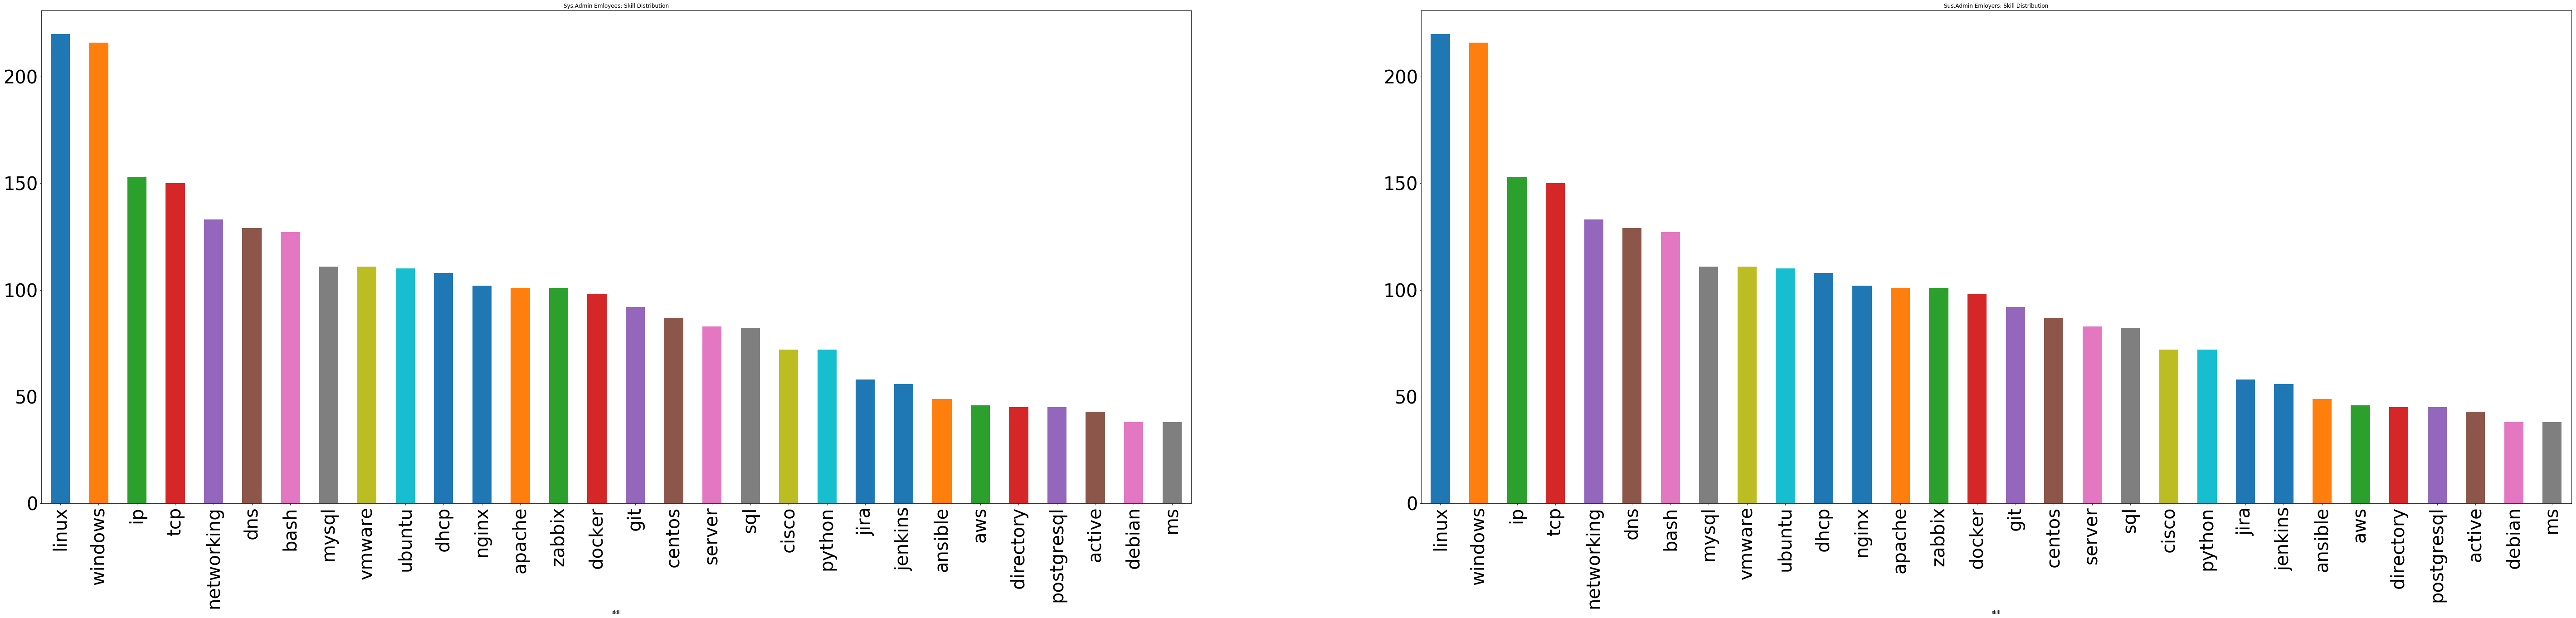

In [61]:
# Checking skills by sys admins emloyers


n = 30
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(100,20))

# loading data for sysadmins
df_sa_skills = data[data['is_sysadmin'] == 1]
top_sa_skills = get_top_n_words(df_sa_skills['skills'].dropna().values, n=n)

# plotting
freq_skills = pd.DataFrame(top_sa_skills, columns = ['skill' , 'count'])
freq_skills.groupby('skill').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Sys.Admin Emloyees: Skill Distribution',fontsize = 40,ax = ax1)

df_sa_skills = df_sa_skills[df_sa_skills['pokes'] >=1]['skills'].dropna()
top_sa_skills = get_top_n_words(df_sa_skills.values, n=n)

freq_skills = pd.DataFrame(top_sa_skills, columns = ['skill' , 'count'])
freq_skills.groupby('skill').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Sus.Admin Emloyers: Skill Distribution',fontsize = 40,ax = ax2)


Ok, now picture is a little bit more clear:

<br> * From employer\`s point of view:
* DevOps suppose to know git, bash and aws as "must have". 
* Sys admin must understand ip, windows, tcp, dns. 

<br> From emloyee\`s point of view, the requirments for the job is kind of similar.
<br> (By point of view I mean taking into consideration candidate, that has at least one poke) 

# Clustering

Now I want to try some clusterization to be performed on skills.
<br> The idea is followed: By encoded skills I will build a representation of each candidate and fit K-Means algorithm to separate them. I will not use labels in this step - I will make it unsupervised. In case of success it will confirm a hypothesis about difference of jobs.
<br> Otherwise, it does not necessary means opposite.

In [47]:
# function to fit algorithm

from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import casual_tokenize
import string

def train_kmeans(skill_list):
    
    # extracting features
    extracted_skills = [casual_tokenize(x.lower()) for x in skill_list]
    extracted_skills = [[y  for y in x  if y not in stopwords.words('english')+stopwords.words('russian')] for x in extracted_skills]
    extracted_skills = [[y  for y in x if y not in string.punctuation ] for x in extracted_skills]
    
    # binarize them into one vector
    encoded_skills = MultiLabelBinarizer().fit_transform(extracted_skills)
    
    # fit K-means
    kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_skills)
    predicted_class = kmeans.predict(encoded_skills)
    
    return kmeans, encoded_skills, predicted_class


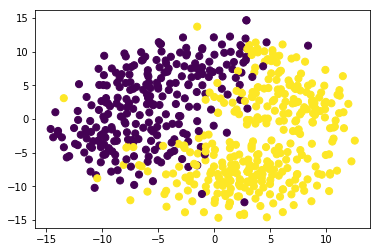

In [56]:
# training model and with the help of TSNE visualize classes

model,skills, predicted_classes = train_kmeans(data['skills'].dropna().values)
two_dim_skills = TSNE(n_components=2).fit_transform(skills)

plt.scatter(two_dim_skills[:, 0], two_dim_skills[:, 1], c=predicted_classes, s=50, cmap='viridis')
plt.show()

Ok, so this is very interesting picture - data can be separated (without labels on two classes), that can be easily visualized. Lets check, whether those classes are the classes we need or just something different.


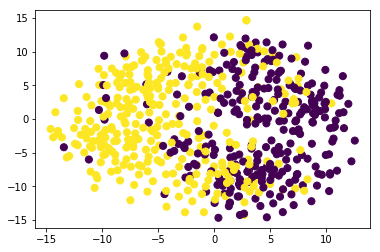

In [58]:
plt.scatter(two_dim_skills[:, 0], two_dim_skills[:, 1], c=data.dropna(subset=['skills'])['is_devops'].values, s=50, cmap='viridis')
plt.show()

So, from given two pictures I can assume, that data could be separated by candidate\`s skills. Moreover, there is an intersection of clusters, exactly how we have in data.

# To  sum up:
there are difference of jobs of DevOps and Sys.Admin.

* Skillsets, that are valuable for candidate of Devops has differences of skillset of sysadmin:
<p> DevOps`s emloyer values understanding of linux, docker, aws, bush as first must have. 
<p> Sys.Admin`s emloyer values understanding of linux, windows, ip, tsp as first must have. 


* Mean salary expectation of DevOpses is higher, than of Sys.Admins.


* DevOpses are trying to use english more, than Sys.Admins during work search.

